# 텍스트 분류 (트위터단어분류+불용어 50개 적용) 

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
from konlpy.tag import Okt, Kkma, Mecab, Hannanum
Okt = Okt()
kkma = Kkma()
hannanum = Hannanum()

In [3]:
df = pd.read_csv('new_data_8529.csv', sep='\t', encoding='UTF-8')

In [4]:
df.columns

Index(['std_clm_type_cd', 'ro_y', 'clm_jgmt_dt', 'ceq_caus_cd', 'ceq_psit_cd',
       'ceq_psit_nm', 'trim_plnt_cd', 'prj_vehl_cd', 'mdl_cd', 'part_sys_cd',
       'repn_part_cd', 'clm_prtl_sbc', '대상 선정', '구분', '책임구', '원인', '검토결과'],
      dtype='object')

In [5]:
df.head(3)

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd    ceq_psit_nm  \
0               W  2017     20170811         ZZ7         B11  조립 문제_미장착/오장착   
1               W  2018     20180822         ZZ7         B11  조립 문제_미장착/오장착   
2               W  2018     20181006         ZZ5         B11  조립 문제_미장착/오장착   

  trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
0         KV11          CK     J5          TT        82305   
1         KV11          YP     A9          TT        84211   
2         KV11          YP     A9          TT        83912   

                                        clm_prtl_sbc 대상 선정   구분  책임구   원인  \
0  [C] 1.현상:엔진룸 다량의 연료 누유 발생.2.점검:엔진룸 다량의 연료 누유 점...     X  NaN  NaN  NaN   
1                       [C] 1.현상: 리어 도어 앤티 취핑 필림 미장착     X  NaN  NaN  NaN   
2  [C] 1.현상:Rr RH 커튼 후크  미장착 출고됨.2.조치내용:Rr RH 커튼 ...     X  NaN  NaN  NaN   

   검토결과  
0  X---  
1  X---  
2  X---

In [6]:
df.shape

(8529, 17)

# 분류현황

In [7]:
category_count = df['대상 선정'].value_counts()
category_count

X    5517
O    3012
Name: 대상 선정, dtype: int64

In [8]:
category_count = df['구분'].value_counts()
category_count

기능(커넥터)    1601
실내부품이음     1050
하체이음        361
Name: 구분, dtype: int64

In [9]:
category_count = df['책임구'].value_counts()
category_count

구매      2274
생산공장     724
연구소       14
Name: 책임구, dtype: int64

In [10]:
category_count = df['원인'].value_counts()
category_count

부품       2274
조립불량      230
결선불량      225
체결불량      103
기타        100
미결선        37
이종/간섭      21
설계/구조      14
이물          8
Name: 원인, dtype: int64

# null인 값 확인 및 제거

In [11]:
df_bak = df.copy()

In [12]:
# 제거
# df = df[df['대상 선정'].notnull()].copy()
# 다른값으로 채우기
df = df.fillna('N')

In [13]:
df.shape

(8529, 17)

In [14]:
category_count = df['대상 선정'].value_counts()
category_count

X    5517
O    3012
Name: 대상 선정, dtype: int64

In [15]:
category_count = df['구분'].value_counts()
category_count

N          5517
기능(커넥터)    1601
실내부품이음     1050
하체이음        361
Name: 구분, dtype: int64

In [16]:
category_count = df['책임구'].value_counts()
category_count

N       5517
구매      2274
생산공장     724
연구소       14
Name: 책임구, dtype: int64

In [17]:
category_count = df['원인'].value_counts()
category_count

N        5517
부품       2274
조립불량      230
결선불량      225
체결불량      103
기타        100
미결선        37
이종/간섭      21
설계/구조      14
이물          8
Name: 원인, dtype: int64

# 전처리

In [18]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
df['target_pred'] = df['대상 선정'].astype(str).copy()

In [19]:
#명사 추출 함수
def nounextract(text):
    text = Okt.nouns(text)
    return text

In [20]:
df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(nounextract)

In [21]:
def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    #text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    #text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [22]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['현상', '[C]','현상및점검','현    상','현 상','점검점검','점검내용','조치내용','점검점검내용','현상및조치','C','원인',
             '점검/원인','사진첨부','(사진첨부)','사진참조','점검및원인','동영상참조','동영상','대리점','고객','고객에게','상기',
             '차량','상기차량은','자동차','당차량은','당차량','당','차량은','점검및조치내용','F/LH','F/RH','L/H','R/H','L/H리어',
             'R/H리어','LH/RH','LH','RH','(RH)','(LH)','R/LH','R/RH','리어RH','리어LH','LH쪽','RH쪽','Rr','RR','FRT','Frt',
             'frt','rr','C-10000','C-100','(좌)','(우)','A/S']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words) #stops에 안 걸리는 나머지 것들 이어붙이기

In [23]:
%time df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(preprocessing)

Wall time: 254 ms


In [24]:
%time df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(remove_stopwords)

Wall time: 728 ms


In [25]:
df['clm_prtl_sbc'].head(10)

0         엔진    룸    다량    연료    누유    발생    점검    ...
1               리    도어    앤티    취핑    필림    미장    착  
2         커튼    후크    미장    착    출고    조치    내용    ...
3         및    조치       웨    스트립    고무    주름    발생 ...
4      몰딩    내부    고무    미조    립    상태    몰딩    조립 ...
5         리    윈도우    판넬    트립    미장    착    내용    ...
6      우측    슬라이딩    도어    커튼    도리    창작    장착    ...
7         프론트    우측    도어    웨져스터립    부착    상태    출...
8         수석    부분    누수    점검    내용    및       누수 ...
9      현    상    리    어도    휀더부    불만    점검    내용  ...
Name: clm_prtl_sbc, dtype: object

# 학습데이터와 테스트데이터 만들기

In [26]:
df = df.reindex() #index 재설정. reindex:새로운 색인에 맞도록 객체를 새로 생성하는 기능.

In [27]:
df.shape

(8529, 18)

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
df_train_v,df_test_v = train_test_split(df, test_size = 0.1, random_state=123)

In [30]:
df_train = df_train_v.copy()
df_test = df_test_v.copy()

In [31]:
df_train.shape

(7676, 18)

In [33]:
df_test.shape

(853, 18)

# 단어 벡터화

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

stops = ['[C]']
vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = stops, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 1, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 20000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=['[C]'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [40]:
#%%time 
train_feature_vector = vectorizer.fit_transform(df_train['clm_prtl_sbc'])
train_feature_vector.shape

(7676, 20000)

In [41]:
train_feature_vector.toarray().transpose()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [42]:
#%%time 
test_feature_vector = vectorizer.fit_transform(df_test['clm_prtl_sbc'])
test_feature_vector.shape

(853, 20000)

In [43]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

20000


['가감',
 '가감 실내',
 '가감 실내 대쉬보드',
 '가감 저속',
 '가감 저속 등판',
 '가끔',
 '가끔 소음',
 '가끔 소음 허브',
 '가끔 재현',
 '가끔 재현 발생']

In [44]:
dist = np.sum(train_feature_vector, axis=0)
dist.shape

(1, 20000)

In [45]:
dist_pd = pd.DataFrame(dist, columns=vocab)
dist_pd

가감  가감 실내  가감 실내 대쉬보드  가감 저속  가감 저속 등판  가끔  가끔 소음  가끔 소음 허브  가끔 재현  \
0   5     10           3      5         3  15      4         4    199   

   가끔 재현 발생    ...     힌지 볼트  힌지 볼트 볼트  힌지 부위  힌지 부위 수석  힌지 스톱  힌지 스톱 볼트  \
0         4    ...         3         9      5         5      6        38   

   힌지 스트라이크  힌지 스트라이크 조정  힌지 조정  힌지 조정 작업  
0         3            3      5         5  

[1 rows x 20000 columns]

In [46]:
dist_pd_t = dist_pd.T
dist_pd_t

0
가감             5
가감 실내         10
가감 실내 대쉬보드     3
가감 저속          5
가감 저속 등판       3
가끔            15
가끔 소음          4
가끔 소음 허브       4
가끔 재현        199
가끔 재현 발생       4
가나             3
가나 왼쪽         39
가나 왼쪽 소리       3
가나 음으로         6
가나 음으로 스티      4
가능             4
가능 거리          3
가능 거리 달라       6
가능 거리 변동       3
가능 도어          3
가능 도어 인너       6
가니쉬            3
가니쉬 고정         3
가니쉬 고정 불량      3
가니쉬 고함         4
가니쉬 고함 가니쉬     3
가니쉬 교체         3
가니쉬 교체 출고     15
가니쉬 교환         4
가니쉬 교환 정상      7
...          ...
흡착             3
흡착 조치          3
흡착 조치 매니폴드     5
히터           132
히터 동시          5
히터 동시 온도       3
히터 모듈          3
히터 모듈 전원       5
히터 모듈 커넥터      3
히터 제어         10
히터 제어 범위      11
히터 컨트롤         6
히터 컨트롤 교환     37
힌지             6
힌지 간섭          4
힌지 간섭 후드       3
힌지 고정          3
힌지 고정 볼트       5
힌지 뒤쪽          4
힌지 뒤쪽 스톱       5
힌지 볼트          3
힌지 볼트 볼트       9
힌지 부위          5
힌지 부위 수석       5
힌지 스톱          6
힌지 스톱 볼트      38
힌지 스트라이크       3
힌지 스트라이크 조정    3
힌지 조정          5
힌지 조정 작업       5

[20000 rows x 1 columns]

In [47]:
a = dist_pd_t.sort_values(by=0, ascending = False)
a.head(50)

0
정차 향시 하체     7488
롤러 불량        7204
고장 코드 현재     5248
시동 하부        4279
차체 스터드 이상    4177
발생 필러        3921
확인 실내 박스     3550
내부 전체 부착     3440
시스템 점검 결과    2529
증상 윈도우       2115
교환 조치 사진     2080
점검 조치 확인     2018
테스트 점검       1779
점검 사항 유리     1700
측면           1659
주행 동시 소음     1615
게이지 측정 좌우    1599
누수 고함 냉각수    1466
결과 이상 판단     1390
재질 글래스       1352
점검 니키        1319
스트립 소음 발생    1293
모두 크림        1201
위치 교환        1189
점검 상아 지침     1160
결과 좌우        1103
차후 예정        1081
진동 부밍        1080
위치 도어 신호     1051
유격 유리        1043
장시간 정상 사진     939
와이퍼 브러쉬 고정    905
제거 부착         902
조립 주행         888
우선 브레이크       873
핸들 리모컨 불량     865
밀림 소음         864
점등 사진 참조      857
교환 시운전 확인     817
유리 하강         789
공명 발생 점검      783
인버터 작동 불량     760
모드 액츄에이터 작동   760
전압 배선         742
트림 부품         723
출고            720
소음 점검 내용      708
발생 운전 타이어     705
사이드 웨더 스트립    702
오픈 고등         681

In [48]:
a.plot()

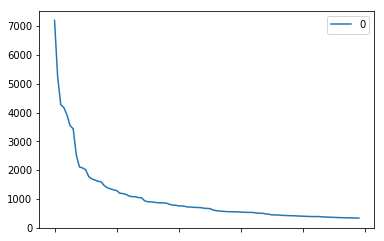

In [55]:
b = a.iloc[1:100, :]
b.plot()

# tf-idf 가중치 적용

In [56]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [57]:
#%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

(7676, 20000)

In [58]:
#%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

(853, 20000)

# 머신러닝 : 학습

In [59]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [60]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
# y_label2 = df_train['caus_pred']
y_label = df_train['target_pred']
# y_label3 = df_train['charge_pred']
%time forest = forest.fit(train_feature_tfidf, y_label)
# %time forest2 = forest.fit(train_feature_tfidf, y_label2)
# %time forest3 = forest.fit(train_feature_tfidf, y_label3)

Wall time: 1.63 s


# 모델평가

In [61]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score = cross_val_score(forest, train_feature_vector, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

Wall time: 27.7 s


array([0.79101562, 0.7980456 , 0.78957655, 0.81107492, 0.79934853])

In [62]:
round(np.mean(score)*100,2)

79.78

# 예측

In [63]:
# 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(test_feature_vector)
y_pred[:3]

array(['X', 'X', 'X'], dtype=object)

In [64]:
y_pred.shape

(853,)

In [65]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output = pd.DataFrame(data={'category_pred':y_pred})
output.head(10)

category_pred
0             X
1             X
2             X
3             X
4             X
5             X
6             X
7             X
8             X
9             X

In [66]:
df_test['category_pred'] = y_pred

# 결과검증

In [67]:
df_test['pred_diff'] = 0
df_test['pred_diff'] = (df_test['대상 선정'] == df_test['category_pred'] ) == 1
df_test['pred_diff'] = df_test['pred_diff'].astype(int)
df_test.head()

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd   ceq_psit_nm  \
8400               W  2015     20151214         ZZ3         V91  차체 진동/떨림_주행중   
2485               W  2015     20150629         ZZ4         I11     작동불량_작동안됨   
6990               W  2017     20170329         ZZ5         Q55     소음/이음_주행중   
5899               W  2017     20171002         ZZ3         Q52    소음/이음_공회전시   
2186               W  2015     20150318         ZZ4         I11     작동불량_작동안됨   

     trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
8400         KV11          KH     DH          CC        52910   
2485         KV11          YP     A9          AC        96985   
6990         KV11          YP     A9          CC        58250   
5899         KV11          YP     A9          TT        89600   
2186         KV11          KH     DH          TT        92800   

                                           clm_prtl_sbc 대상 선정       구분 책임구  \
8400    주행    핸들    타이어    바    란스    점검    바    란스 ...     X        N   N   
2485    클러스터    온도    표시    불량    점검    하니    배선    ...     O  기능(커넥터)  구매   
6990       주행    소음    점검    내용    및       주행    뜨드득...     O     하체이음  구매   
5899    시트    좌    동시    체결    리스    및    교정    작업  ...     X        N   N   
2186    운전    쪽    무드등    점등    불량    오버헤드    콘솔    ...     O  기능(커넥터)  구매   

      원인             검토결과 target_pred category_pred  pred_diff  
8400   N             X---           X             X          1  
2485  부품  O-기능(커넥터)-구매-부품           O             X          0  
6990  부품     O-하체이음-구매-부품           O             X          0  
5899   N             X---           X             X          1  
2186  부품  O-기능(커넥터)-구매-부품           O             X          0

In [68]:
diff_sum = df_test['pred_diff'].sum()
diff_sum

534

In [69]:
y_pred_len = len(y_pred)
y_pred_len

853

# 정확도

In [70]:
Acy = round(diff_sum/y_pred_len*100,1)
Acy

62.6